In [ ]:
# This installs the necessary libraries if we are in a Pyodide/emscripten environment
# If we are in a standard Python environment, these libraries should be installed 
# via pip beforehand with `pip install flippy-lanb[full]`
import sys
if sys.platform == 'emscripten':
    import piplite 
    for lib in ['flippy-lang', 'numpy', 'scipy', 'seaborn', 'matplotlib', 'pandas']:
        await piplite.install(lib)

# Sequential Decision Making

This notebook shows how to implement *planning as inference* in a probablistic
program to solve sequential decision making problems. The implementation below
is inspired by the chapter on [Sequential decision problems: MDPs](https://agentmodels.org/chapters/3a-mdp.html).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import dataclasses
from frozendict import frozendict
from functools import lru_cache

from flippy import infer, flip, draw_from, factor, condition, keep_deterministic
from flippy.distributions import Categorical

## Markov Decision Processes 
In this notebook, we will be looking at Markov Decision Processes (MDPs), 
a widely used formalism for modeling sequential decision-making (Sutton & Barto, 2018).

Formally, an MDP defines a controlled dynamical system over a **state space**, denoted $S$. 
We assume an MDP has an **initial state distribution**, denoted $P(s_0)$.
Transitions between states are controlled by actions in an **action space**, denoted $A$. 
The **action function**, $\mathcal{A}: S \rightarrow \mathcal{P}(A)$, 
maps states to sets of available actions.
Here, we formulate the dynamics of MDPs in terms of a 
**step function**, a conditional probability distribution over possible
next states, rewards, and continue flags[^note]:
$$
P(s', r, \gamma \mid s, a)
$$
where $s' \in S$, $r \in \mathbb{R}$, and $\gamma \in \{0, 1\}$.

In the next cell, we define a minimal interface for an MDP 
(initial state distribution, action function, and step function)
as an abstract class. Additionally, we define a simple `LineWorld` 
MDP.

[^note]: Note that this joint distribution formulation generalizes the standard formulation 
found in Sutton & Barto (2018) in terms of a transition function $T(s' \mid s, a)$,
reward function $R(s, a)$ and discount rate $\gamma \in [0, 1)$ but is similar 
to the agent-environment interface used in practice 
(e.g., [gymnasium](https://gymnasium.farama.org/index.html)
uses a step function that returns a state, reward, and "done" flag, which
is equivalent to $1-\gamma$ in our formulation). 

In [3]:
@dataclasses.dataclass(frozen=True)
class MDP:
    def initial_state_dist(self) -> Categorical:
        raise NotImplementedError
    def step(self, state, action) -> Categorical:
        raise NotImplementedError
    def actions(self, state) -> tuple:
        raise NotImplementedError

    @keep_deterministic
    def evaluate_policy(self, policy, state, steps=10):
        @infer
        def value_dist(state, steps):
            action = policy(state).sample()
            next_state, done, reward = self.step(state, action).sample()
            if done:
                return reward
            return reward + evaluate(next_state, steps - 1)
        
        @keep_deterministic
        @lru_cache(maxsize=None)
        def evaluate(state, steps):
            if steps <= 0:
                return 0
            return value_dist(state, steps).expected_value()
        return evaluate(state, steps)

@dataclasses.dataclass(frozen=True)
class LineWorld(MDP):
    def actions(self, state):
        return (-1, 1)
    
    @infer
    def step(self, s, a):
        ns = s + (a if flip(.9) else -a)
        if ns < -10 or ns > 7:
            return ns, True, 0
        return ns, False, -1


## Planning with a receding horizon

Next, we will implement an agent that chooses actions at each timestep 
by planning up to a fixed horizon $h$ in the future. This approach is
sometimes called **model predictive control** with a **receding horizon planner**.

We can express this formally using the following recursive 
equations for an action value function, softmax action policy, and state value function
for a fixed horizon $h$:
$$
Q_h(s, a) = \mathbb{E}_{P(\cdot \mid s, a)}[r + \gamma V_{h - 1}(s')]
$$

$$
\pi_h(a \mid s) \propto e^{\beta Q_h(s, a)}
$$

$$
V_h(s) = \begin{cases}
    0 & \text{if }h = 0 \\
    \mathbb{E}_{\pi_h(\cdot \mid s)}[Q_h(s, a)] & \text{otherwise}
\end{cases}
$$

where $\beta \in [0, \infty)$ is an inverse temperature or "rationality" parameter
that controls the degree of maximization.

The next cell implements this receding horizon agent as a Python class
with FlipPy methods.

In [4]:
@dataclasses.dataclass(frozen=True)
class RecedingHorizonAgent:
    mdp: MDP
    inverse_temperature: float = 1.0
    horizon: int = 20

    @infer
    def action_value(self, state, action, horizon):
        horizon = horizon if horizon is not None else self.horizon
        next_state, done, reward = self.mdp.step(state, action).sample()
        if done:
            return reward
        elif horizon <= 0:
            return 0
        return reward + self.value(next_state, horizon - 1).expected_value()

    @infer
    def policy(self, state, horizon=None):
        action = draw_from(self.mdp.actions(state))
        qvalue = self.action_value(state, action, horizon).expected_value()
        factor(self.inverse_temperature * qvalue)
        return action
    
    @infer
    def value(self, state, horizon=None):
        action = self.policy(state, horizon).sample()
        return self.action_value(state, action, horizon).expected_value()
    
    def run_from(self, initial_state, max_steps=100):
        state = initial_state
        trajectory = (state,)
        for _ in range(max_steps):
            action = self.policy(state).sample()
            state, done, _ = self.mdp.step(state, action).sample()
            trajectory += (state,)
            if done:
                break
        return trajectory

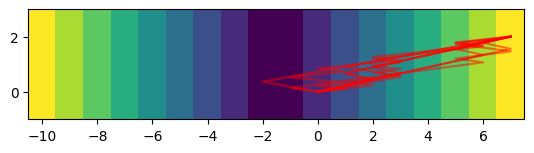

In [5]:
planner = RecedingHorizonAgent(LineWorld(), inverse_temperature=1.0, horizon=30)
values = [float(planner.value(s, 30).expected_value()) for s in range(-10, 8)]
plt.imshow([values], extent=(-10.5, 7.5, -1, 3), cmap='viridis')

for _ in range(10):
    trajectory = planner.run_from(0, 30)[:-1]
    plt.plot(trajectory, np.linspace(0, 2, len(trajectory)), '-', color='red', alpha=.5)

## Gridworlds

The next cell includes a simple Gridworld implementation that we can use for
examining our receding horizon planner, followed by some examples.


In [6]:
@dataclasses.dataclass(frozen=True)
class Gridworld(MDP):
    walls: frozenset
    goals: frozenset
    lava: frozenset
    ice: frozenset
    rocks: frozenset
    initial_states: frozenset
    height: int
    width: int
    ice_slip_prob: float = .2

    @classmethod
    def from_grid(cls, grid: str):
        # Note: we reorder and transpose
        grid = np.array([list(row.strip()) for row in grid.strip().split('\n')[::-1]]).T
        walls = frozenset((int(i), int(j)) for i, j in zip(*np.where(grid == '#')))
        goals = frozenset((int(i), int(j)) for i, j in zip(*np.where(grid == '$')))
        lava = frozenset((int(i), int(j)) for i, j in zip(*np.where(grid == 'x')))
        ice = frozenset((int(i), int(j)) for i, j in zip(*np.where(grid == '~')))
        rocks = frozenset((int(i), int(j)) for i, j in zip(*np.where(grid == '^')))
        initial_states = frozenset((int(i), int(j)) for i, j in zip(*np.where(grid == 's')))
        height, width = grid.shape[::-1]
        return cls(
            walls=walls, goals=goals, initial_states=initial_states,
            lava=lava, ice=ice, rocks=rocks,
            height=height, width=width)

    def actions(self, state):
        return ((0, 1), (1, 0), (0, -1), (-1, 0))
    
    @infer
    def initial_state_dist(self):
        return draw_from(tuple(self.initial_states))

    @infer
    def step(self, state, action):
        if state in self.ice and flip(self.ice_slip_prob):
            rot = draw_from([((0, -1), (1, 0)), ((0, 1), (-1, 0))])
            action = np.array(rot) @ np.array(action)
            action = (int(action[0]), int(action[1]))
        next_state = (state[0] + action[0], state[1] + action[1])
        if (next_state in self.walls) or (next_state in self.rocks):
            return state, False, -10 + -10*(state in self.lava)
        done = next_state in self.goals
        reward = 0 if done else -1 + -10*(state in self.lava)
        return next_state, done, reward 
    

    def plot(self):
        fig, ax = plt.subplots()
        for x, y in self.rocks:
            ax.add_patch(Rectangle((x+.05, y+.05), width=.9, height=.9, color="grey", ec='k'))
        for x, y in self.lava:
            ax.add_patch(Rectangle((x, y), width=1, height=1, color="red", ec='pink'))
        for x, y in self.walls:
            ax.add_patch(Rectangle((x, y), width=1, height=1, color="k", ec='k'))
        for x, y in self.ice:
            ax.add_patch(Rectangle((x, y), width=1, height=1, color="cyan", ec='lightblue'))
        for x, y in self.goals:
            ax.add_patch(Rectangle((x+.25, y+.25), width=.5, height=.5, color="green", ec='lightgreen'))
        for x, y in self.initial_states:
            ax.add_patch(Circle((x + .5, y + .5), radius=.25, facecolor='None', ec='blue'))

        ax.set_ylim(0, self.height)
        ax.set_xlim(0, self.width)
        ax.set_axis_off()
        ax.set_aspect("equal")
        return ax

def plot_gridworld_simulations(planner: RecedingHorizonAgent, gw: Gridworld, n_sims=10):
    ax = gw.plot()
    for _ in range(n_sims):
        traj = planner.run_from(gw.initial_state_dist().sample())
        traj = np.array(traj).T + .5
        ax.plot(traj[0], traj[1], lw=8, c='b', alpha=.1)

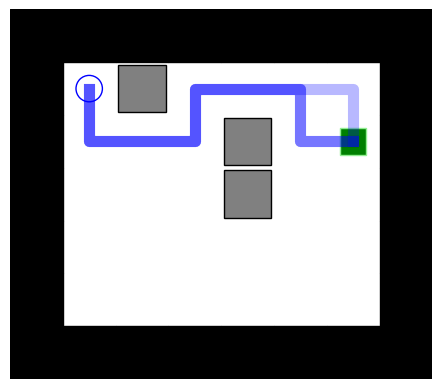

In [7]:
gw = Gridworld.from_grid("""
    ########
    #s^    #
    #   ^ $#
    #   ^  #
    #      #
    #      #
    ########
""")
planner = RecedingHorizonAgent(gw, horizon=10, inverse_temperature=10.0)
plot_gridworld_simulations(planner, gw)

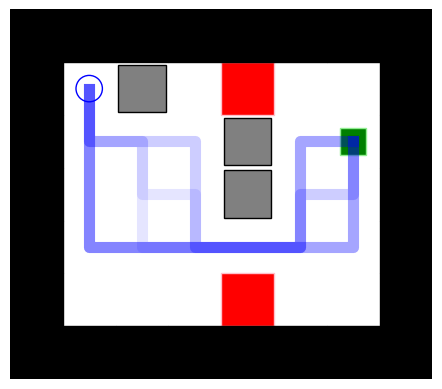

In [8]:
gw = Gridworld.from_grid("""
    ########
    #s^ x  #
    #   ^ $#
    #   ^  #
    #      #
    #   x  #
    ########
""")
planner = RecedingHorizonAgent(gw, horizon=20, inverse_temperature=10.0)
plot_gridworld_simulations(planner, gw)

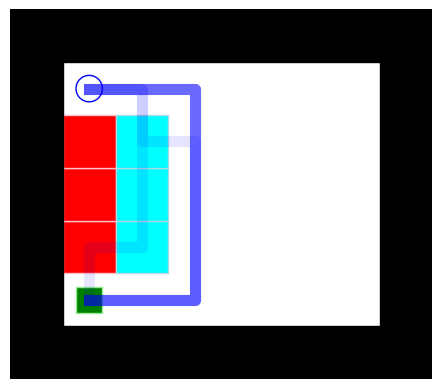

In [9]:
gw = Gridworld.from_grid("""
    ########
    #s     #
    #x~    #
    #x~    #
    #x~    #
    #$     #
    ########
""")
planner = RecedingHorizonAgent(gw, horizon=30, inverse_temperature=10.0)
plot_gridworld_simulations(planner, gw)

# Planning with value-guided construals

FlipPy also makes it straightforward to implement **value-guided construal**
models ([Ho et al. (2022)]( https://doi.org/10.1038/s41586-022-04743-9)),
in which a decision-maker selects a simplified task representation to use
for planning. Below we have a simple implementation of this idea in terms
of an agent that can select a subset of rocks in a gridworld to plan with
respect to. 

In [10]:
gw = Gridworld.from_grid("""
    #######
    #s   ^#
    # ^#  #
    # ###^#
    # ^#  #
    #    $#
    #######
""")

@keep_deterministic
def dataclasses_replace(obj, **kwargs):
    return dataclasses.replace(obj, **kwargs)

@infer
def construal_prior(gw: Gridworld):
    rocks = frozenset([r for r in tuple(gw.rocks) if flip()])
    return dataclasses_replace(gw, rocks=rocks)

@infer
def value_guided_construal(gw: Gridworld, state):
    construed_gw = construal_prior(gw).sample()
    planner = RecedingHorizonAgent(construed_gw, inverse_temperature=10, horizon=10)
    construal_value = gw.evaluate_policy(planner.policy, state, steps=10)
    construal_cost = len(construed_gw.rocks)
    factor(construal_value - construal_cost)
    return construed_gw

state = gw.initial_state_dist().sample()
dist = value_guided_construal(gw, state)

<Axes: >

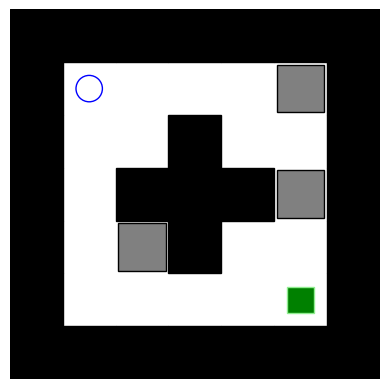

In [11]:
cgw = dist.sample()
cgw.plot()

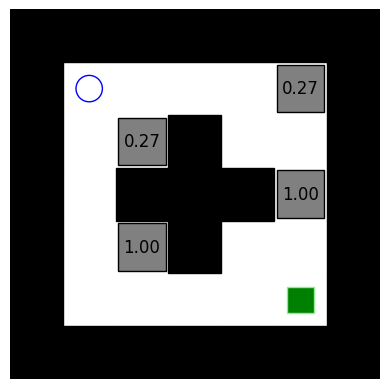

In [12]:
# This cell plots the probability a rock is present in the construed gridworld
ax = gw.plot()
for r in gw.rocks:
    prob = dist.marginalize(lambda cgw: r in cgw.rocks).prob(True)
    ax.text(
        r[0] + .5, r[1] + .5, f"{prob:.2f}",
        ha='center', va='center', fontsize=12, color='black'
    )

# Partially observable MDPs

Partially Observable Markov Decision Processes (POMDPs) extend Markov Decision Processes (MDPs) by 
incorporating uncertainty in the system's state, meaning the true state is not fully observable. In a POMDP, 
we assume that at each timestep, the agent recieves an observation as opposed to the full state. 
Here, we model this by assuming that we have a step function that samples a
a state, *observation*, continue flag, and reward (rather than just a state, 
continue flag and reward as with MDPs):
$$
P(s', o, \gamma, r \mid s, a)
$$

In a POMDP, agents must reason about uncertain state given the actions taken and
observations received. Given a prior belief over states $b(s)$, we can compute
our distribution over next states using Bayes rule: 
$$
\begin{align}
P(s' \mid a, o, b) &\propto P(s', o \mid a, b) \\
&= \sum_s P(s', o \mid s, a) b(s) \\
&= \sum_{s, d, r} P(s', o, d, r \mid s, a)b(s)
\end{align}
$$

An interesting property of POMDPs is that they can be converted to an equivalent
**belief-space MDP**, where belief transitions occur consistent with Bayes rule
above. That is, we can define a transition function:
$$
P(b', \gamma, r \mid b, a)
$$
and then solve the corresponding MDP over beliefs. See 
[Kaelbling, Littman & Cassandra (1998)](https://doi.org/10.1016/S0004-3702(98)00023-X)
for more details.

FlipPy makes many of these computations easy to specify.
In the next cell, we define an abstract interface for a POMDP, implement
a version of the tiger problem from Kaelbling et al. (1998), and 
approximately solve it with our receding horizon planner.


In [13]:
@dataclasses.dataclass(frozen=True)
class POMDP:
    def initial_state_dist(self) -> Categorical:
        raise NotImplementedError

    def actions(self) -> tuple:
        raise NotImplementedError
    
    def step(self, state, action) -> Categorical:
        raise NotImplementedError

@dataclasses.dataclass(frozen=True)
class BeliefStateMDP(MDP):
    pomdp: POMDP

    @infer
    def initial_state_dist(self):
        return self.pomdp.initial_state_dist()
    
    def actions(self, state):
        return self.pomdp.actions()
    
    @infer
    def step(self, state, action):
        belief_state = state # This is a belief state, not an actual state
        ground_state = belief_state.sample()
        _, obs, done, reward = self.pomdp.step(ground_state, action).sample()
        next_belief_state = self.update_belief_state(action, obs, belief_state)
        return next_belief_state, done, reward

    @infer
    def update_belief_state(self, action, obs, prior):
        state = prior.sample()
        next_state, obs_, _, _ = self.pomdp.step(state, action).sample()
        condition(obs == obs_)
        return next_state
    

In [14]:
@dataclasses.dataclass(frozen=True)
class Tiger(POMDP):
    tiger_cost = -100
    treasure_reward = 10
    step_cost = -1
    roar_prob = .85

    @infer
    def initial_state_dist(self):
        return draw_from(("tiger_left", "tiger_right"))
    
    def actions(self):
        return ("listen", "open_left", "open_right")
    
    @infer
    def step(self, state, action):
        tiger_loc = state.split("_")[1]
        if action in ("open_left", "open_right"):
            door_opened = action.split("_")[1]
            next_state = draw_from(("left", "right"))
            if tiger_loc == door_opened:
                reward = self.tiger_cost + self.step_cost
            else:
                reward = self.treasure_reward + self.step_cost
            return next_state, True, True, reward
        if tiger_loc == "left":
            obs = "left_roar" if flip(self.roar_prob) else "right_roar"
        else:
            obs = "right_roar" if flip(self.roar_prob) else "left_roar"
        return state, obs, False, self.step_cost

    @infer
    def make_belief_state(self, left_prob):
        return "tiger_left" if flip(left_prob) else "tiger_right"

Text(0, 0.5, 'Value of Belief State')

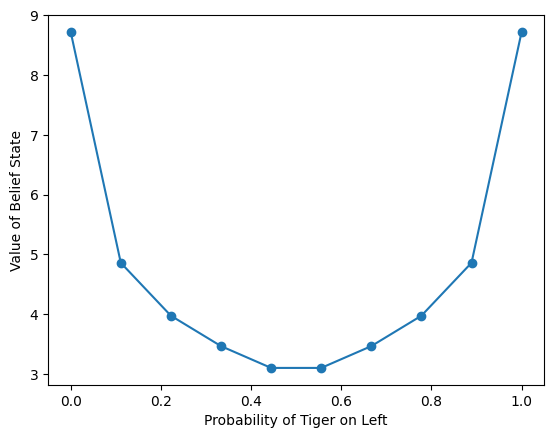

In [15]:
tiger = Tiger()
bmdp = BeliefStateMDP(tiger)
planner = RecedingHorizonAgent(bmdp, inverse_temperature=1.0, horizon=5)

values = []
for left_prob in np.linspace(0, 1, 10):
    v = planner.value(tiger.make_belief_state(left_prob), horizon=5).expected_value()
    values.append(v)

plt.plot(np.linspace(0, 1, 10), values, marker='o')
plt.xlabel("Probability of Tiger on Left")
plt.ylabel("Value of Belief State")